## ISS projekt - piano
xjirmu00
Jirmusová Veronika
VUT FIT 2022

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interactive, fixed, IntSlider


from PIL import Image
from matplotlib.patches import Rectangle

import scipy.signal as ss
import soundfile as sf
from IPython.display import display
from IPython.display import Audio

## 1 Vzorek siglálů

Signály byly navzorkované pomocí kódu pana profesora, který byl v zadání, do kterého bylo poté pouze doplněno vykreslování do grafů. Audio bylo vytvořrno pomocí funkce sf.write().

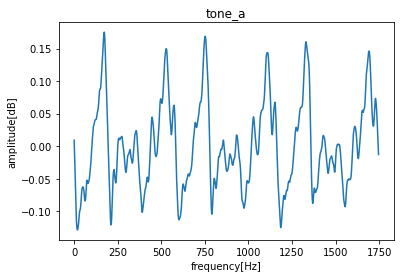

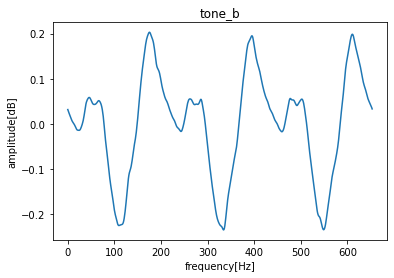

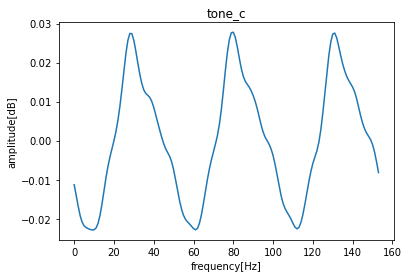

In [45]:
MIDIFROM = 24                   #honza's code here
MIDITO = 108
SKIP_SEC = 0.25
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2
howmanytones = MIDITO - MIDIFROM + 1
tones = np.arange(MIDIFROM, MIDITO+1)
s, Fs = sf.read("klavir.wav")
N = int(Fs * HOWMUCH_SEC)
Nwholetone = int(Fs * WHOLETONE_SEC)
xall = np.zeros((MIDITO+1, N))  # matrix with all tones - first signals empty,
                                # but we have plenty of memory ...
samplefrom = int(SKIP_SEC * Fs)
sampleto = samplefrom + N

for tone in tones:
    x = s[samplefrom:sampleto]
    x = x - np.mean(x) # safer to center ...
    xall[tone,:] = x
    samplefrom += Nwholetone
    sampleto += Nwholetone
    

#sf.write("a_orig.wav", xall[40], Fs)
#sf.write("b_orig.wav", xall[57], Fs)
#sf.write("c_orig.wav", xall[82], Fs)
plt.plot(xall[40][0:int(3*Fs//82.41)]) #tone a - MIDI 40, Frq 82.41
plt.title("tone_a")
plt.xlabel("frequency[Hz]")
plt.ylabel("amplitude[dB]")
plt.show()
plt.plot(xall[57][0:int(3*Fs//220.00)]) #tone b - MIDI 57, Frq 220.00
plt.title("tone_b")
plt.xlabel("frequency[Hz]")
plt.ylabel("amplitude[dB]")
plt.show()
plt.plot(xall[82][0:int(3*Fs//932.33)]) #tone c - MIDI 82, Frq 932.33
plt.title("tone_c")
plt.xlabel("frequency[Hz]")
plt.ylabel("amplitude[dB]")
plt.show()



##  DFT 
DFT se tvoří pomocí funkce np.fft.fft(), díky čemuž můžeme vytvořit graf DFT. Vykreslují se nám ale imaginární složky na reálné ose, proto bylo potřeba aplikovat absolutní hodnotu na tyto hodnoty, abych se problému zbavila (inspirace z notebooku 02 pana profesora). Tyto hodnoty je poté potřeba 'rozpůlit' pro lepší vizualizaci. Funkce plt.figure() určí velikost grafu v palcích a do něj pak vykresluji výsledné DFT.

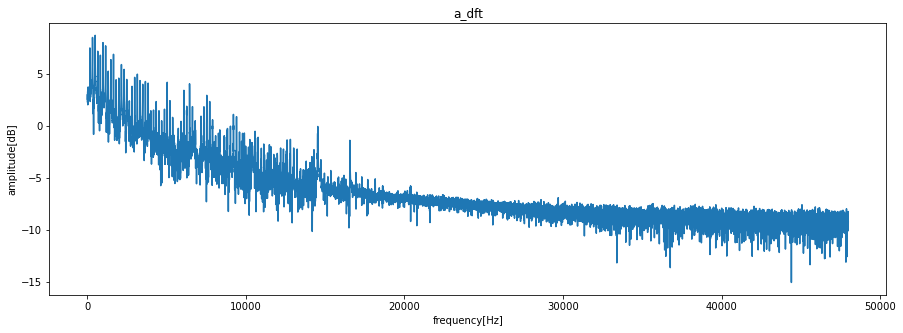

In [51]:
#tone_a
a_dft = xall[40]
a_dft = np.fft.fft(a_dft)
a_dft = np.abs(a_dft)
a_dft = a_dft[:a_dft.size//2]
idk = np.arange(a_dft.size)*Fs / (a_dft.size)

plt.figure(figsize=(15,5))

plt.plot(idk[1:], np.log2(a_dft[1:]))
plt.title("a_dft")
plt.xlabel("frequency[Hz]")
plt.ylabel("amplitude[dB]")
plt.show()

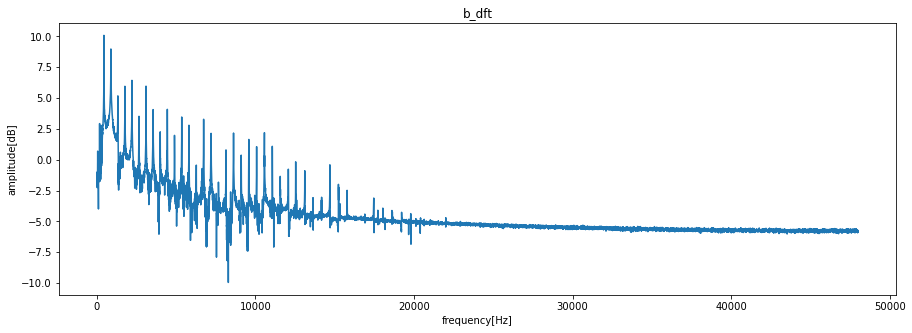

In [49]:
#tone_b
b_dft = xall[57]
b_dft = np.fft.fft(b_dft)
b_dft = np.abs(b_dft)
b_dft = b_dft[:b_dft.size//2]
idk = np.arange(b_dft.size)*Fs / (b_dft.size)

plt.figure(figsize=(15,5))

plt.plot(idk[1:], np.log2(b_dft[1:]))
plt.title("b_dft")
plt.xlabel("frequency[Hz]")
plt.ylabel("amplitude[dB]")
plt.show()

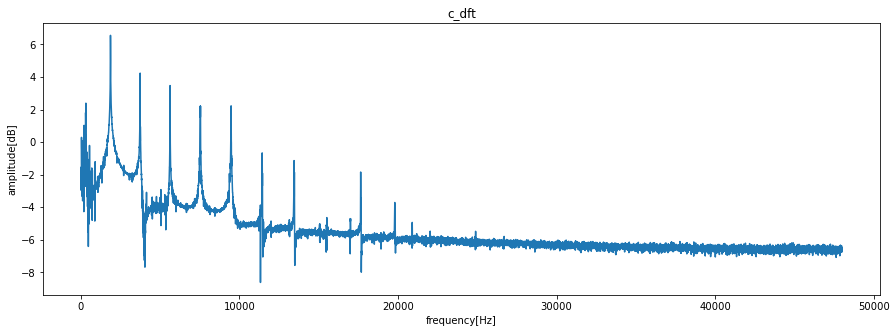

In [42]:
#tone_c
c_dft = xall[82]
c_dft = np.fft.fft(c_dft)
c_dft = np.abs(c_dft)
c_dft = c_dft[:c_dft.size//2]
idk = np.arange(c_dft.size)*Fs / (c_dft.size)

plt.figure(figsize=(15,5))

plt.plot(idk[1:], np.log2(c_dft[1:]))
plt.title("c_dft")
plt.xlabel("frequency[Hz]")
plt.ylabel("amplitude[dB]")
plt.show()

## 2. Autokorelace + DFT
Dále byla provedena autokorelace pro MIDI 24 - 41 a DTF pro vyšší MIDI z toho důvodu, že autokorelace funguje přesněji pro nižší frekvence a DFT naopak. Jednotlivé frekvence jsem počítala tak, že jsem zavolala funkci np.correlate() v módu 'full' a odečetla jsem druhý největší 'peak' od největšího a to jsem následně vynásobila Fs.

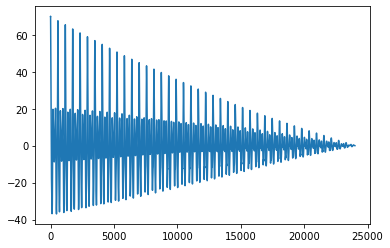

In [61]:

i = 24
f0 = np.zeros(MIDITO+1)
for tone in xall[i:41]:
    autocorr = np.correlate(tone, tone, mode = 'full')
    autocorr = autocorr[autocorr.size//2-1:]
    b1 = ss.find_peaks(autocorr, max(autocorr)//1.4)[0][0]
    b2 = ss.find_peaks(autocorr, max(autocorr)//1.4)[0][1]
    f0[i] = 1/(b2-b1)*Fs

    #print(i, Fs/(b2-b1), file=open("output.txt", 'a'))
    i += 1
plt.plot(autocorr[:autocorr.size])
plt.show()


In [27]:
i = 41
for tone in xall[41:]:
    idkman = np.fft.fft(tone)
    fuf = (np.arange(idkman.size)*Fs / (idkman.size))[np.argmax(np.abs(idkman[:idkman.size//2]))]
    print(i, fuf)
    f0[i] = fuf
    i += 1
    

41 88.0
42 92.0
43 98.0
44 104.0
45 110.0
46 118.0
47 124.0
48 130.0
49 138.0
50 146.0
51 156.0
52 164.0
53 350.0
54 370.0
55 392.0
56 208.0
57 220.0
58 234.0
59 248.0
60 262.0
61 278.0
62 294.0
63 312.0
64 330.0
65 350.0
66 370.0
67 392.0
68 416.0
69 440.0
70 466.0
71 494.0
72 524.0
73 554.0
74 588.0
75 622.0
76 660.0
77 698.0
78 740.0
79 784.0
80 830.0
81 882.0
82 932.0
83 988.0
84 1046.0
85 1108.0
86 1174.0
87 1244.0
88 1318.0
89 1396.0
90 1478.0
91 1566.0
92 1660.0
93 1758.0
94 1864.0
95 1976.0
96 2094.0
97 2218.0
98 2350.0
99 2490.0
100 2638.0
101 2796.0
102 2962.0
103 3138.0
104 3324.0
105 3522.0
106 3732.0
107 3954.0
108 4188.0


## 3. DTFT 

In [28]:
#DTFT i guess
for i in range (MIDIFROM, MIDITO + 1, 1):
    tone = xall[i,:]

    RANGE = 5
    FREQPOINTS = 1000
    f = f0[i]


    n = np.arange(0, tone.size)
    A = np.zeros([int(RANGE*2/0.01)+1, tone.size],dtype=complex)   
    q = 0
    for k in np.arange(f - RANGE, f + RANGE, 0.01):
        A[q,:] = np.exp(-1j * 2 * np.pi * k * (n/tone.size))  
        q += 1 # norm. omega = 2 * pi * f / Fs ... 
        #cos = np.matmul(np.cos(2*np.pi*k*(n/N)), xall[tone,:].T)
        #sin = np.matmul(np.sin(2*np.pi*k*(n/N)), xall[tone,:].T)
        
    Xdtft = np.matmul(A, tone.T)


    #plt.plot(np.arange(f - RANGE, f + RANGE, 0.01), np.abs(Xdtft))
    #plt.show()

    dtft = np.abs(Xdtft)
    #d1 = ss.find_peaks(dtft[dtft.size//2:], max(dtft[dtft.size//1.85:])//1.85)[0][0]
    #d2 = ss.find_peaks(dtft[dtft.size//2:], max(dtft[dtft.size//1.85:])//1.85)[0][1]
    #print(f)
    precisefmax = np.arange(f - RANGE, f + RANGE, 0.01)[np.argmax(np.abs(Xdtft))]
    print(i, precisefmax)



24 32.67450511945469
25 34.62227206946531
26 36.68160919540306
27 38.87103896103799
28 41.172570937230326
29 43.62584699453454
30 46.22204633204536
31 48.96975460122603
32 51.86805194805097
33 54.969070034442204
34 58.233207776426724
35 61.64567010309183
36 65.31377049180233
37 69.1945441389315
38 73.43689127105918
39 77.81207792208043
40 82.41422680412624
41 87.35000000000223
42 92.53000000000283
43 98.02000000000257
44 103.87000000000249
45 110.03000000000257
46 116.58000000000183
47 123.18000000000214
48 130.4300000000028
49 138.1699999999953
50 147.08999999999446
51 155.87999999999556
52 165.17999999999438
53 349.8599999999956
54 370.66999999999484
55 392.7199999999948
56 208.11999999999534
57 220.489999999995
58 233.59999999999582
59 247.45999999999594
60 262.1699999999953
61 277.75999999999567
62 293.399999999996
63 310.8399999999965
64 329.31999999999607
65 349.2699999999961
66 370.0399999999954
67 392.0299999999954
68 415.5299999999959
69 440.19999999999527
70 466.3499999999951

## 4